# A Basic Example of Topic Modeling

This is an example of how to perform topic modeling.

There are several hyperparameters for the algorithms. There are two different topic modeling algorithms implemented in this example, non-negative matrix factorization (NMF) and Latent Dirichlet Allocation (LDA).

In [1]:
# Necessary for importing modules from a sub-directory
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
if os.getcwd().split('/')[-1] == 'notebook_examples':
    os.chdir(r"../")


# Importing libraries
import pandas_gbq
import pickle
import numpy as np
import pandas as pd
import gensim
import matplotlib.pyplot as plt

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import matutils, models, corpora
#from src.efselabwrapper.pipeline import run_processing_pipeline

## Data Settings
This is where the parameters are set for choosing which articles to perform topic modeling with.

The number of articles needs to big enough to make the statistical relationships between the words reliable, hence giving meaningful topics. For advanced analysis we recommend this to be bigger than 5000, preferably around 10 000. To preprocess 10 000 articles takes about 1.5-2 minutes (which is the most time-consuming part of the modeling).

In [2]:
PREPROCESSED = True

if PREPROCESSED:
    pickle_filename = 'data/preprocessed/sv_news_articles_50000.pickle'
    preprocessed_corpus = pickle.load(open(pickle_filename, 'rb'))
    
else:
    # tags to choose:
    # ['PROPN', 'NOUN', 'ADJ', 'VERB', 'ADV', 'SCONJ', 'AUX', 'PUNCT', 'ADP', 'PRON','DET', 'PART', 'CCONJ', 'NUM', 'INTJ']
    pos_tags = ["NOUN"]
    
    # Preprocess
    #preprocessed_corpus = run_processing_pipeline(df, pos_tags)

## Model Settings
This is where parameters for the modeling are chosen.
Part of Speech Tags (pos_tags) represents which Part of Speach classes are used in the modeling. In this example, all classes except nouns are filtered out.

The number of topics can be chosen as well as which algorithm to use. Which algorithm to use is highly use case dependent, hence there is no general best algorithm. A throughout comparison between the two algorithms can be found in our thesis (link in README), but as a short summary one can say that NMF is faster and creates more specific topics while LDA is slower and create more general and comprehensive topics.

In [3]:
# Choose algorithm, LDA or NMF
algorithm = 'NMF' #'NMF' | 'LDA'

# Number of topics
NUM_TOPICS = 40

# NMF settings
NMF_NORM = 'frobenius' # ‘frobenius’ | ‘kullback-leibler’ | ‘itakura-saito’
NMF_SOLVER = 'mu' # ‘cd’ | ‘mu’
INIT = None # None | ‘random’ | ‘nndsvd’ | ‘nndsvda’ | ‘nndsvdar’ | ‘custom’
ALPHA = 0 # float

## Build Topic Model

In [4]:
if algorithm == 'LDA':
    # Set mallet path
    mallet_path ='src/mallet-2.0.8/bin/mallet'
    
    # Format Gensim components for data
    id2word = corpora.Dictionary(preprocessed_corpus)
    id2word.filter_extremes(no_below=2)
    corpus = [id2word.doc2bow(text) for text in efselab_parsed_corpus]

    # Train model
    model = models.wrappers.LdaMallet(mallet_path,
                                      corpus=corpus,
                                      id2word=id2word,
                                      num_topics=NUM_TOPICS)
    topics = model.show_topics(num_topics=NUM_TOPICS, num_words=10, formatted=False)
    
    doc_topic_weights = np.array([[e[1] for e in doc] for doc in model[corpus]])

    
if algorithm == 'NMF':
    # Create TF-IDF
    vectorizer = TfidfVectorizer(
        lowercase=False,
        tokenizer=lambda x: x,
        max_df=0.95,
        min_df=2,
        max_features=None,
        use_idf=True
    )
    tf_idf = vectorizer.fit_transform(preprocessed_corpus)
    feature_names = vectorizer.get_feature_names()
    
    # Train model
    model = NMF(random_state=0, tol=0.0001, verbose=0, shuffle=False,\
            n_components=NUM_TOPICS, beta_loss=NMF_NORM, solver=NMF_SOLVER, \
            init=INIT, alpha=ALPHA, max_iter=500)

    W = model.fit_transform(tf_idf, y=feature_names)
    H = model.components_   

    def get_NMF_topics(model, feature_names, n_top_words):
        all_topics = []
        for topic_idx, topic in enumerate(model.components_):
            sumtopic = np.sum(topic)
            topic_formatted = (topic_idx, [(feature_names[i], topic[i]/sumtopic) for i in topic.argsort()[:-n_top_words - 1:-1]])
            all_topics.append(topic_formatted)
        return all_topics

    topics = get_NMF_topics(model, feature_names, 10)
    doc_topic_weights = W

doc_topic = [np.argmax(e) for e in doc_topic_weights]
topic_counts = [doc_topic.count(i) for i in range(len(topics))]


## Print Topics

T1: sverige land regering fråga värld arbete förslag möjlighet stockholm samhälle 
T2: polis presstalesperson plats händelse natt brott misshandel mord inbrott gärningsman 
T3: match mål lag poäng seger period halvlek säsong spel tränare 
T4: krona miljon kvartal resultat bolag rörelseresultat omsättning skatt vinst utdelning 
T5: kommun kommunstyrelse krona verksamhet förskola peng ordförande markaryd boende förslag 
T6: bil olycka räddningstjänst väg ambulans trafik förare lastbil klocka trafikolycka 
T7: patient läkare behandling läkemedel vård vårdcentral sjuksköterska sjukhus ivo medicin 
T8: kvinna misshandel våldtäkt barn åtal jämställdhet ofredande relation skadestånd jönköping 
T9: kina hongkong usa land coronavirus peking virus börs tull taiwan 
T10: barn förälder förskola familj mamma skola pappa flicka liv läkare 
T11: trump president usa donald demokrat nordkorea biden kongress hus ukraina 
T12: brand räddningstjänst larm byggnad plats mordbrand eld hus lägenhet befäl 
T13

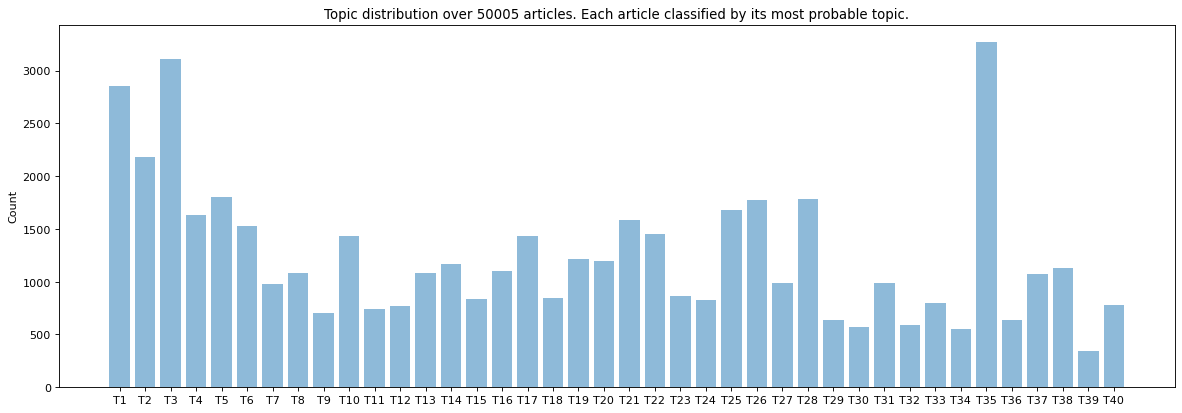

In [5]:
for topic in topics:
    print(f'T{topic[0]+1}:', ' '.join([f'{e[0]}' for e in topic[1]]), '')
    
# Plot bar chart
plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
topic_axis = [f'T{i+1}' for i in range(len(topics))]
y_pos = np.arange(len(topic_axis))
plt.bar(y_pos, topic_counts, align='center', alpha=0.5)
plt.xticks(y_pos, topic_axis)
plt.ylabel('Count')
plt.title(f'Topic distribution over {sum(topic_counts)} articles. Each article classified by its most probable topic.')
plt.show()

In [8]:
import pyLDAvis
pyLDAvis.enable_notebook()

if algorithm == 'LDA':
    import pyLDAvis.gensim
    conv_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(model)
    
if algorithm == 'NMF':
    W_norm = W / W.sum(axis=1)[:, None]
    H_smooth = np.add(H, 0.000000000001)
    H_norm = H_smooth / H_smooth.sum(axis=1)[:, None]
    term_freq = tf_idf.sum(axis=0).getA1()
    doc_len = tf_idf.sum(axis=1).getA1()

    opts = {'vocab': feature_names, 
            'doc_lengths': doc_len.tolist(),
            'term_frequency': term_freq.tolist(),
            'doc_topic_dists': W_norm.tolist(),
            'topic_term_dists': H_norm.tolist(),
            'sort_topics': False
           }
    
pyLDAvis.gensim.prepare(conv_model, corpus, id2word, sort_topics=False) if algorithm == 'LDA' else pyLDAvis.prepare(**opts)

/home/jblad/anaconda3/envs/topic_m/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.027430  0.006394       1        1  8.896722
1     -0.129633 -0.051359       2        1  3.012929
2     -0.133685  0.101457       3        1  5.367837
3      0.248916 -0.066200       4        1  2.954205
4     -0.087595 -0.239044       5        1  2.841593
5     -0.090330 -0.026101       6        1  2.529604
6      0.008721 -0.210976       7        1  1.848272
7     -0.100596  0.047576       8        1  1.893807
8      0.159817  0.138711       9        1  1.527779
9     -0.146896  0.038541      10        1  2.921839
10     0.114999  0.164459      11        1  1.602238
11    -0.124839 -0.005843      12        1  1.550982
12     0.155313 -0.097655      13        1  2.534390
13     0.109254  0.095027      14        1  2.429692
14    -0.130384 -0.011558      15        1  1.510050
15     0.230209  0.028499      16        1  1.888165
16     0.131246 -0.122462      17        1  2.398660
17     0.100813  0.094683      18        1  1.584111
18    -0.066081 -0.007239      19        1  2.424251
19     0.009903  0.055832      20        1  2.399856
20    -0.081804  0.042912      21        1  2.753112
21     0.101997 -0.018053      22        1  2.697248
22    -0.029654 -0.215236      23        1  1.945140
23     0.286436  0.007203      24        1  1.566149
24    -0.002580 -0.059181      25        1  3.015111
25     0.098954  0.026738      26        1  2.833555
26    -0.166186  0.021875      27        1  2.198067
27    -0.120353  0.156441      28        1  3.970119
28     0.189738 -0.048756      29        1  1.516605
29    -0.023769  0.014552      30        1  2.344006
30    -0.094607  0.027144      31        1  2.218342
31    -0.041722 -0.196563      32        1  1.319566
32    -0.039010 -0.213984      33        1  1.760412
33    -0.115581  0.022765      34        1  1.195240
34    -0.119588  0.151379      35        1  5.344169
35     0.062565  0.142907      36        1  1.482248
36    -0.050709  0.196004      37        1  2.347411
37    -0.046770 -0.099401      38        1  2.292491
38     0.006280  0.138365      39        1  1.367547
39    -0.045358 -0.029853      40        1  1.716479, topic_info=           Term        Freq       Total Category  logprob  loglift
85504     polis  787.000000  787.000000  Default  30.0000  30.0000
60128    kvinna  693.000000  693.000000  Default  29.0000  29.0000
56338    kommun  635.000000  635.000000  Default  28.0000  28.0000
58687     krona  736.000000  736.000000  Default  27.0000  27.0000
7513       barn  594.000000  594.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
75768    måndag   25.973739  158.215105  Topic40  -5.2423   2.2580
61727      land   27.566346  305.455964  Topic40  -5.1828   1.6597
121558    vecka   29.591266  568.023695  Topic40  -5.1119   1.1102
87637   prognos   22.850213  100.709091  Topic40  -5.3704   2.5816
32204    fredag   24.184412  196.507397  Topic40  -5.3137   1.9699

[3628 rows x 6 columns], token_table=        Topic      Freq            Term
term                                   
23         39  0.920869             .16
75          3  0.134133           a_lag
75         21  0.849509           a_lag
122        31  1.021401            aabo
148        16  0.121514         ab.säte
...       ...       ...             ...
129853      4  1.207314  överskottsgrad
129886     28  0.934949     översättare
129887     28  0.858407    översättning
129906     21  1.199761   övertidsdrama
129982      6  0.942480   öxnehagaleden

[9024 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40])